### Bài tập 2: Bitcoin forecasting


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./data/BTC-Daily.csv')

# remove duplicate rows
df = df.drop_duplicates()

In [3]:
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


2014-11-28 to 2022-03-01


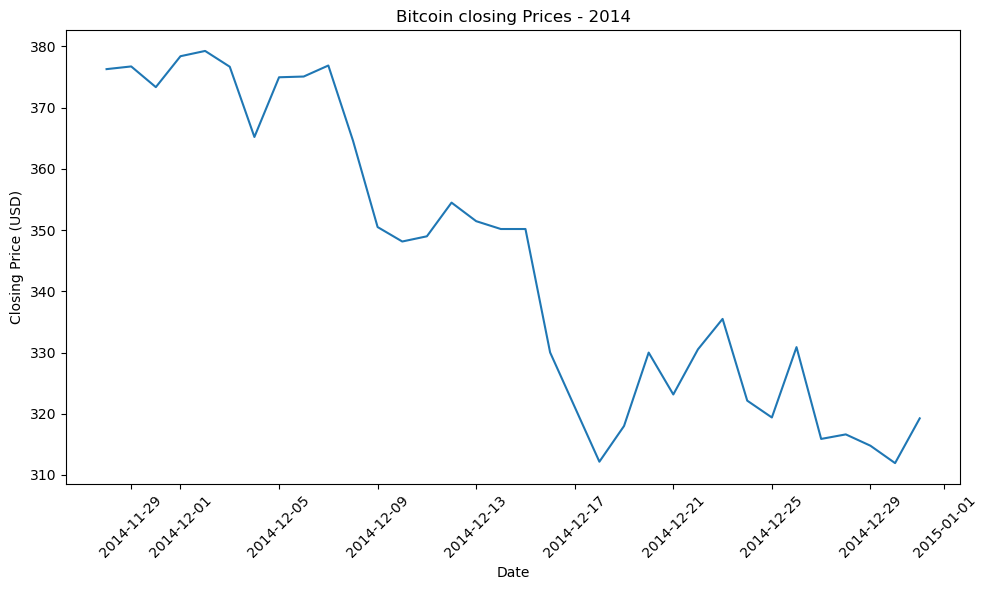

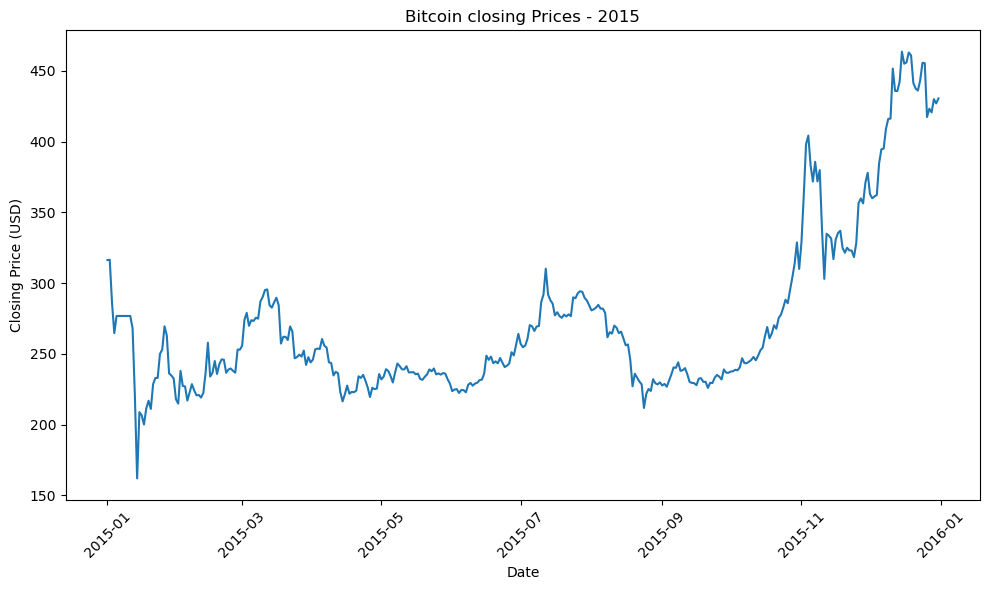

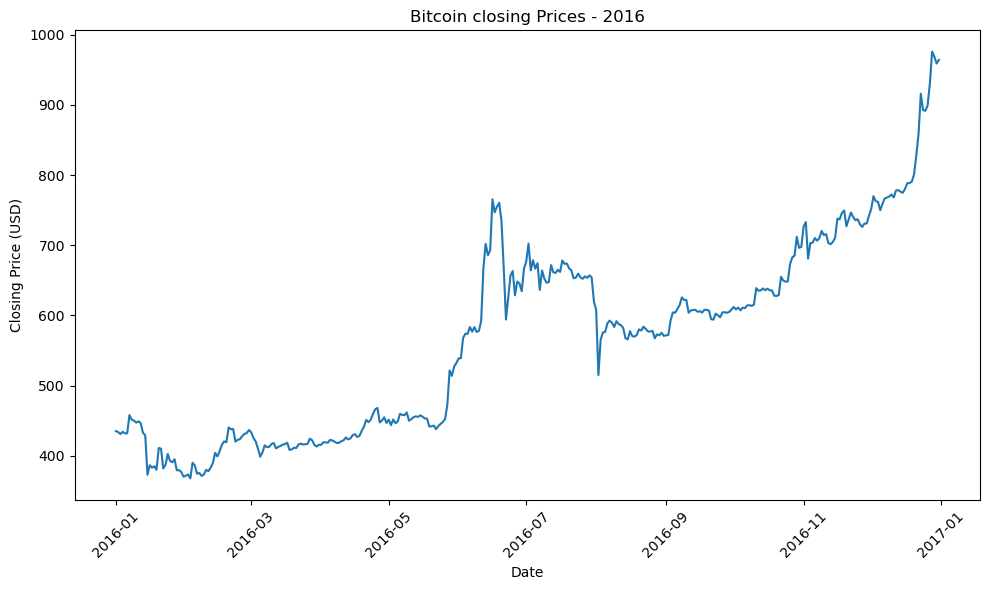

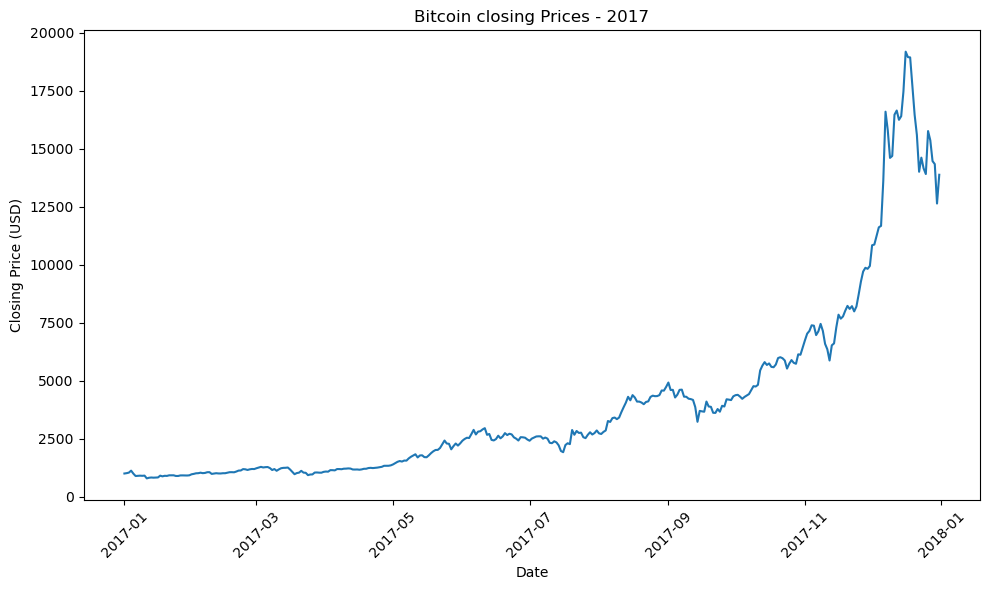

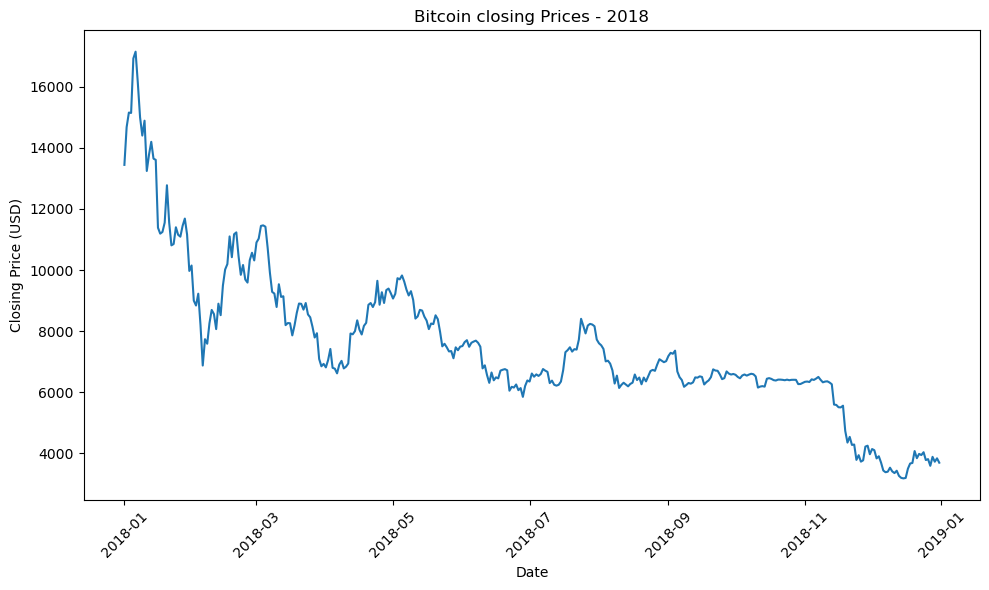

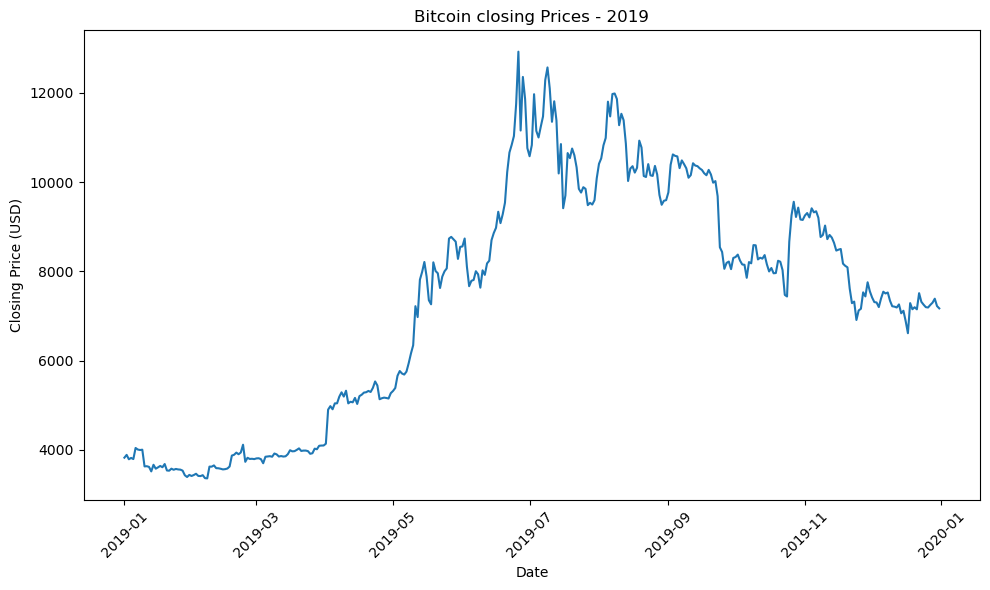

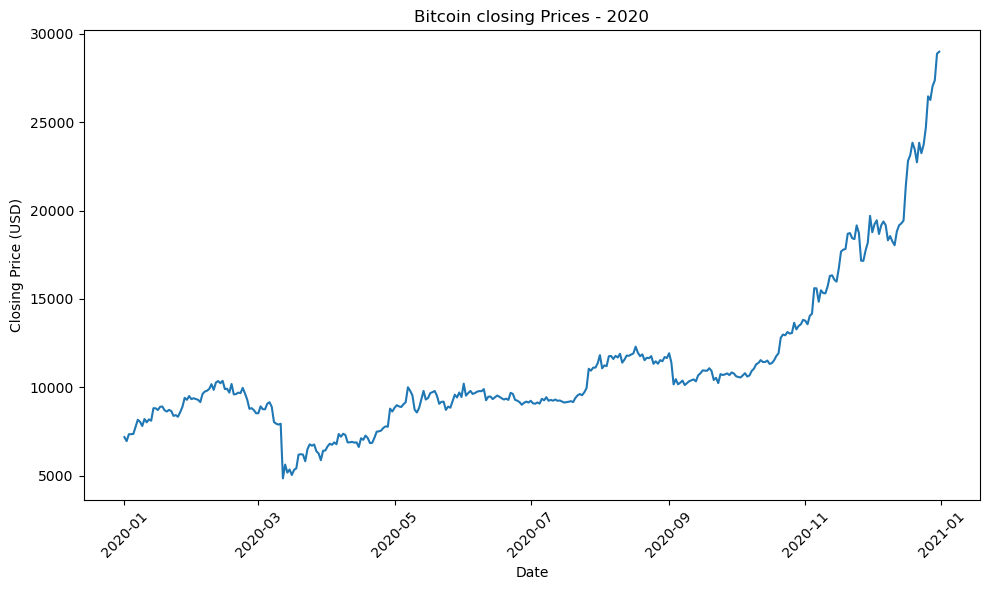

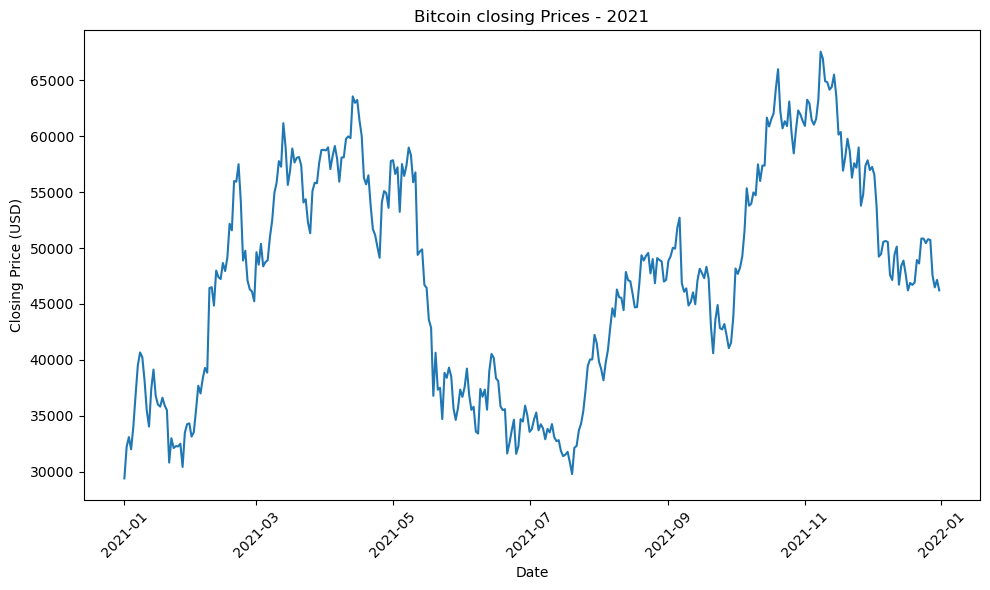

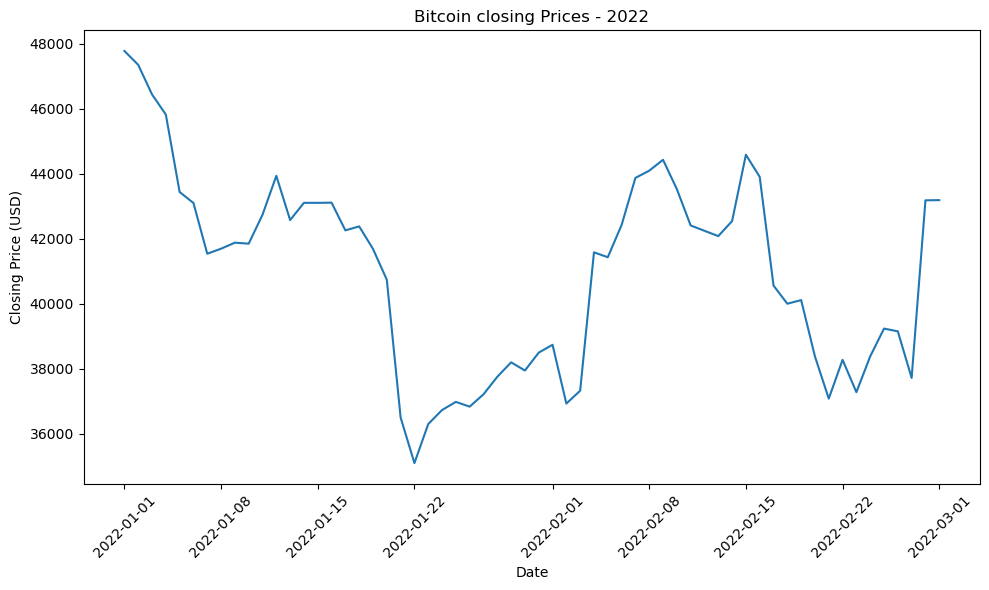

In [4]:
# Range of dates covered
df['date'] = pd.to_datetime(df['date'])
date_range = str(df['date'].dt.date.min()) + ' to ' + \
    str(df['date'].dt.date.max())
print(date_range)

unique_years = np.unique(df['date'].dt.year.values)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

for year in unique_years:
    year_month_day = df[df['year'] == year]

    merged_data = pd.merge(year_month_day, df, on=[
                           'year', 'month', 'day'], how='left')
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(merged_data['date_x'], merged_data['close_x'])
    plt.title(f'Bitcoin closing Prices - {year}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\FPTSHOP\AppData\Local\Temp\ipykernel_27256\2341731915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['date'].map(mdates.date2num)


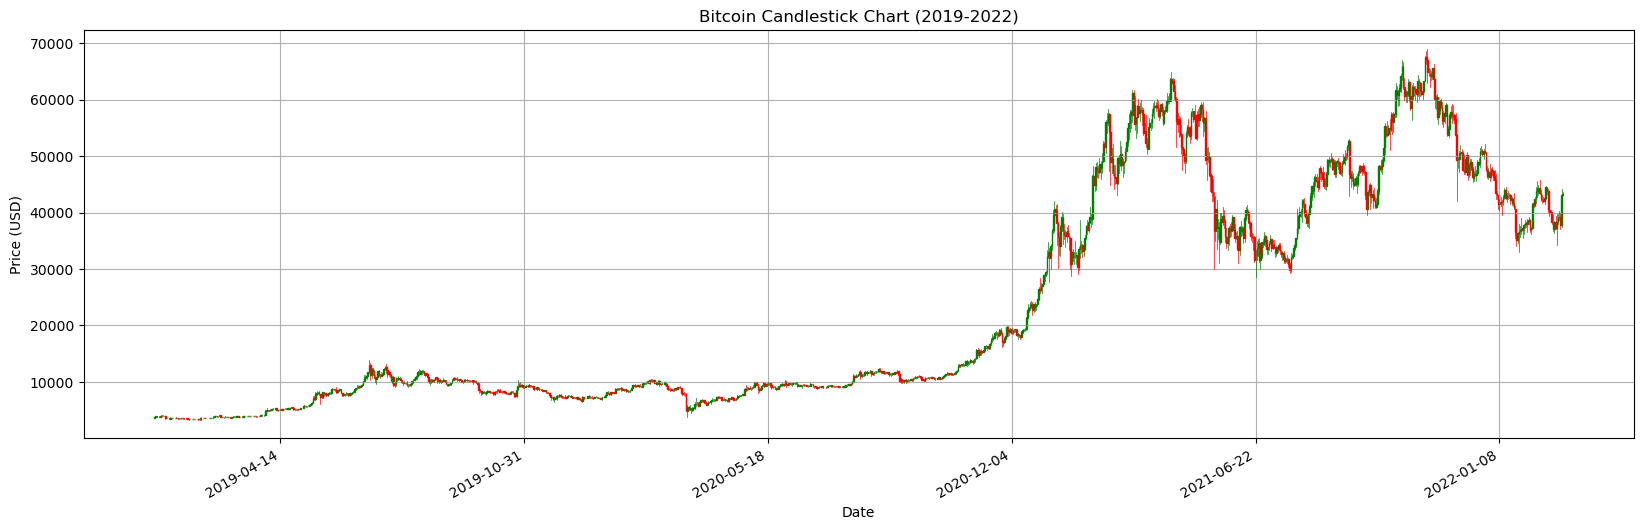

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime

# Filter data for 2019-2022
df_filtered = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2022-12-31')]

# Convert date to matplotlib format
df_filtered['date'] = df_filtered['date'].map(mdates.date2num)

# Create the candlestick chart
fig, ax = plt.subplots(figsize=(20, 6))

candlestick_ohlc(ax, df_filtered[['date', 'open', 'high', 'low', 'close']].values,
                 width=0.6, colorup='g', colordown='r')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.title('Bitcoin Candlestick Chart (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)

# Save the plot as a PDF
plt.savefig('bitcoin_candlestick_2019_2022.pdf')
plt.show()

#### 4. Tạo mô hình linear Regression


In [6]:
def predict(X, w, b):
    return X.dot(w) + b


def gradient(y_hat, y, x):
    loss = y_hat-y
    dw = x.T.dot(loss)/len(y)
    db = np.sum(loss)/len(y)
    cost = np.sum(loss**2)/(2*len(y))
    return (dw, db, cost)


def update_weight(w, b, lr, dw, db):
    w_new = w - lr*dw
    b_new = b - lr*db
    return (w_new, b_new)

#### 5. Chuẩn hóa dữ liệu và chia tập train, test


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
df["Standardized_Close_Prices"] = scaler.fit_transform(
    df["close"].values.reshape(-1, 1))
df["Standardized_Open_Prices"] = scaler.fit_transform(
    df["open"].values.reshape(-1, 1))
df["Standardized_High_Prices"] = scaler.fit_transform(
    df["high"].values.reshape(-1, 1))
df["Standardized_Low_Prices"] = scaler.fit_transform(
    df["low"].values.reshape(-1, 1))
df['NumericalDate'] = pd.to_numeric(df['date'].dt.strftime('%Y%m%d%H%M%S'))

X = df[[
        'Standardized_Open_Prices',
        "Standardized_High_Prices",
        "Standardized_Low_Prices",
        ]]
y = df['Standardized_Close_Prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True)

#### 6. Huấn luyện mô hình


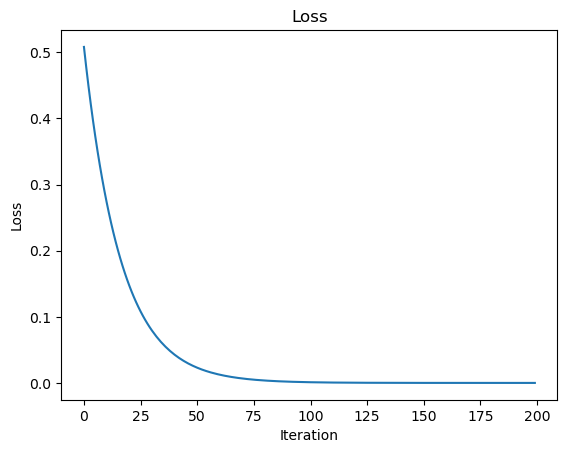

In [8]:
def linear_regression_vectorized(X, y, learning_rate=0.01, num_iterations=200):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)  # Initialize weights
    b = 0  # Initialize bias
    losses = []

    for _ in range(num_iterations):
        y_hat = predict(X, w, b)  # Make predictions
        dw, db, cost = gradient(y_hat, y, X)  # Calculate gradients
        # Update weights and bias
        w, b = update_weight(w, b, learning_rate, dw, db)
        losses.append(cost)

    return w, b, losses


w, b, losses = linear_regression_vectorized(X_train.values, y_train.values,
                                            learning_rate=0.01,
                                            num_iterations=200)

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

#### 7. Đánh giá mô hình Linear Regression


In [9]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred = predict(X_test, w, b)

# Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

# Calculate MAE
mae = np.mean(np.abs(y_pred - y_test))

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


# Calculate R-squared on training data
y_train_pred = predict(X_train, w, b)
train_accuracy = r2_score(y_train, y_train_pred)

# Calculate R-squared on testing data
test_accuracy = r2_score(y_test, y_pred)

print("Root Mean Square Error (RMSE):", round(rmse, 4))
print("Mean Absolute Error (MAE):", round(mae, 4))
print("Training Accuracy (R-squared):", round(train_accuracy, 4))
print("Testing Accuracy (R-squared):", round(test_accuracy, 4))

Root Mean Square Error (RMSE): 0.0293
Mean Absolute Error (MAE): 0.0138
Training Accuracy (R-squared): 0.9989
Testing Accuracy (R-squared): 0.9991


#### 8. Inference: Thực nghiệm mô hình trên giá từ 01/01/2019 - 01/04/2029


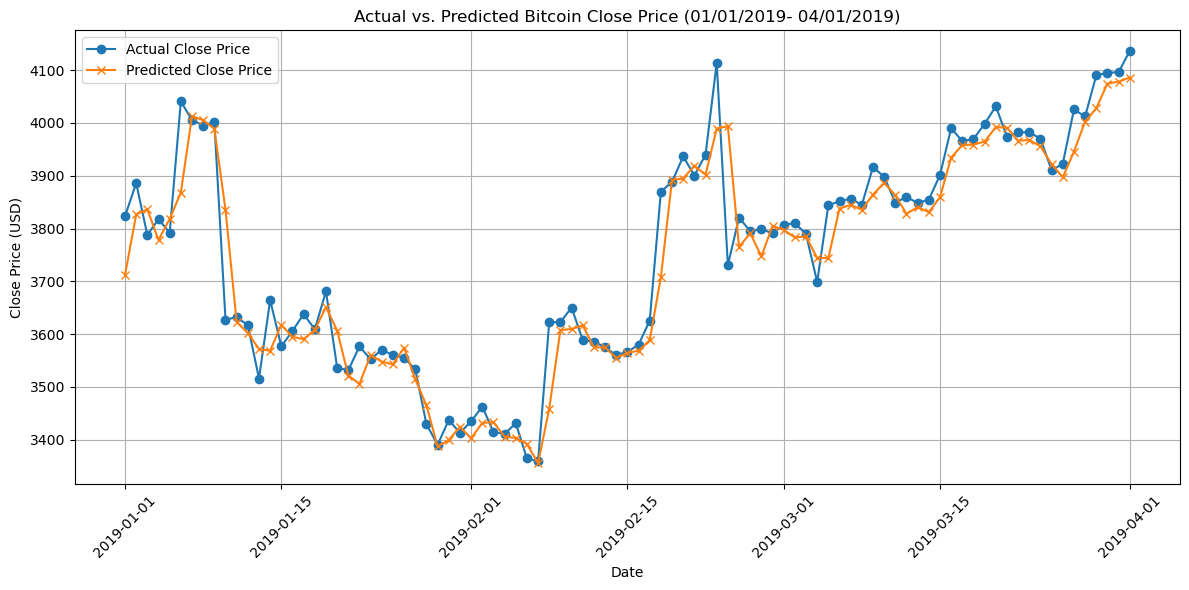

In [10]:
# Filter data for 2019-01-01 to 2019-04-01
df_2019_q1 = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2019-04-01')]

# Prepare X and y for prediction
X_2019_q1 = df_2019_q1[["open", "high", "low"]]
y_2019_q1_actual = df_2019_q1["close"]

y_2019_q1_pred = predict(X_2019_q1, w, b)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_2019_q1['date'], y_2019_q1_actual,
         label='Actual Close Price', marker='o')
plt.plot(df_2019_q1['date'], y_2019_q1_pred,
         label='Predicted Close Price', marker='x')
plt.title('Actual vs. Predicted Bitcoin Close Price (01/01/2019- 04/01/2019)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()